Dataset Link

https://www.kaggle.com/c/data-science-bowl-2018

In [0]:
!pip install tensorflow==1.14.0

In [0]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input,BatchNormalization,Activation
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf
from model_metrics import *

In [0]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = '/content/drive/My Drive/DATASETS/medical data/stage1_train'
TEST_PATH = '/content/drive/My Drive/DATASETS/medical data/stage1_test'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [0]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [0]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + '/' +id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

np.save("/content/drive/My Drive/DATASETS/medical data/X_train_256.npy",X_train)
np.save("/content/drive/My Drive/DATASETS/medical data/Y_train_256.npy",Y_train)

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [4:40:55<00:00, 25.16s/it]


In [0]:
X_train = np.load("/content/drive/My Drive/DATASETS/medical data/X_train.npy")
Y_train = np.load("/content/drive/My Drive/DATASETS/medical data/Y_train.npy")

X_test = np.load("/content/drive/My Drive/DATASETS/medical data/X_test.npy")

In [0]:
Y_train.shape

(670, 128, 128, 1)

In [0]:
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH +'/'+id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
np.save("/content/drive/My Drive/DATASETS/medical data/X_test_256.npy",X_test)
print('Done!')

Getting and resizing test images ... 


100%|██████████| 65/65 [00:57<00:00,  1.13it/s]

Done!


In [0]:
np.save("/content/drive/My Drive/DATASETS/medical data/X_test.npy",X_test)

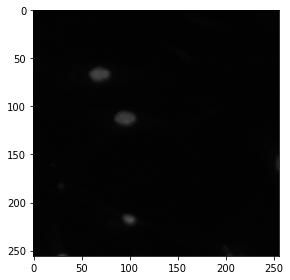

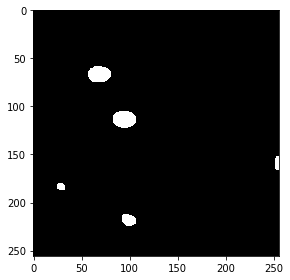

In [0]:
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [0]:
model = BCDU_net_D3(input_size = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),metrics = dice_coef)

/content/temp.py:190: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = conv9)


In [0]:
from keras.callbacks import ModelCheckpoint, TensorBoard,ReduceLROnPlateau
mcp_save = ModelCheckpoint('model_BCDU.h5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
history = model.fit(X_train,Y_train,
              batch_size=16,
              epochs=3,
              shuffle=True,
              verbose=1,
              validation_split=0.1, callbacks=[mcp_save, reduce_lr_loss] )

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Train on 603 samples, validate on 67 samples
Epoch 1/3


In [0]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=2, callbacks=[earlystopper, checkpointer])


Train on 603 samples, validate on 67 samples
Epoch 1/2
603/603 [==============================] - 120s 200ms/step - loss: 0.4365 - mean_iou: 0.3984 - val_loss: 0.3036 - val_mean_iou: 0.4603

Epoch 00001: val_loss improved from inf to 0.30359, saving model to model-dsbowl2018-1.h5
Epoch 2/2
603/603 [==============================] - 116s 193ms/step - loss: 0.2047 - mean_iou: 0.5316 - val_loss: 0.2865 - val_mean_iou: 0.5835

Epoch 00002: val_loss improved from 0.30359 to 0.28651, saving model to model-dsbowl2018-1.h5


In [0]:
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - 3s 48ms/step


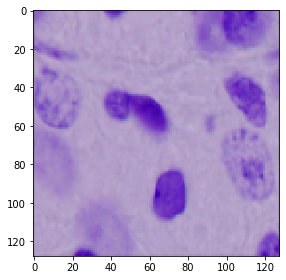

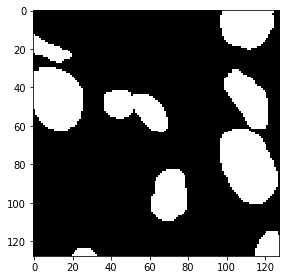

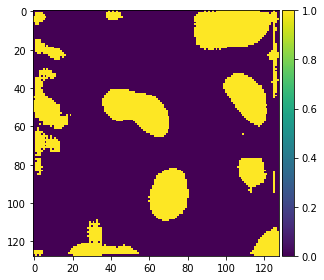

In [0]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

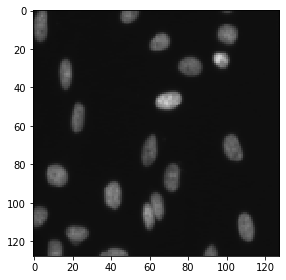

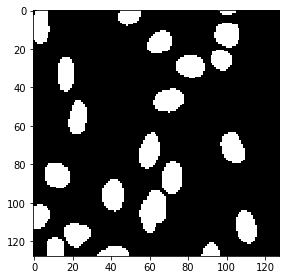

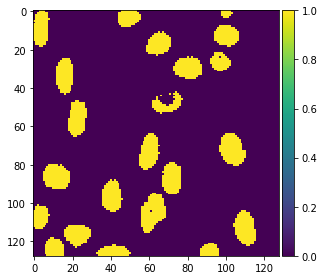

In [0]:
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [0]:
import cv2
im = cv2.imread("/content/drive/My Drive/DATASETS/medical data/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/07a9bf1d7594af2763c86e93f05d22c4d5181353c6d3ab30a345b908ffe5aadc.png")


In [0]:
im.shape

(256, 256, 3)

In [0]:
img = imread("/content/27_884,-17_39_4.png")

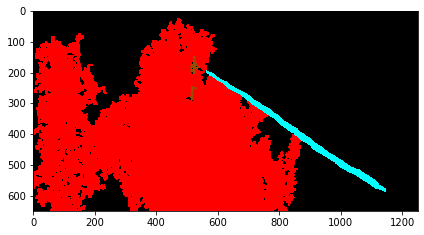

In [0]:
imshow(img)
plt.show()

In [0]:
img[1,2,0]

(650, 1250, 3)